# Pseudodata Again
To generate data with realistic uncertainties, a scheme is derived that is based on choosing an _effective_ number of events when measuring asymmetries. The use of the word "effective" accounts for the fact that in practice the estimates of the number of events in each of two different _states_ (labelled $(+)$ and $(-)$, say) need to take into account factors such as degree of polarisation of beams, targets, recoils, target dilution and background subtraction. Rather than try to account for all of this in the first instance, we thus define the effective number of events $n_e$, which will likely be smaller than the measured number $n_m$. A first guess to the size of an effective number would be around 1000, based on experience with fitting g8 data.

First assume that there is a function $f(x)$ to generate data from. For example, it could be a combination of Legendre Polynomials. If the observable to simulate is an asymmetry then $a = f(x) \in [-1,+1]$. A generated asymmetry pseudodatum $A$ is a random variable that depends on the pseudodata representing the number of counts in each of the two states, $N_+$ and $N_-$:

$$
A = \frac{N_+ - N_-}{N_+ + N_-}.
$$

Now the random variables $N_+$ and $N_-$ can be generated from "true" values $n_+$ and $n_-$:

\begin{align*}
n_+ &= \frac{1}{2} n_e (1 + a); \\
n_- &= \frac{1}{2} n_e (1 - a)
\end{align*}

by drawing them from normal distributions

$$
N_{\pm} \sim {\cal N}(n_{\pm}, \sqrt{n_{\pm}}),
$$

where we are using the fact that the uncertainty in a counting estimate is given by the square root of the number.

```{margin}
Strictly speaking the distributions should be Poisson for counting statistics, but we will make the assumption that $N_+, N_- >> 10$ - can always change this if necessary.
```

To evaluate the uncertainty ($\delta A$) for the generated pseudodatum, just use the standard propagation of errors:

$$
(\delta A)^2 = \left( \frac{\partial A}{\partial N_+} \right)^2 (\delta N_+)^2 +
\left( \frac{\partial A}{\partial N_-} \right)^2 (\delta N_-)^2,
$$

which, since

\begin{align}
\frac{\partial A}{\partial N_+} &= \frac{2 N_-}{N_+ + N_-}; \\
\frac{\partial A}{\partial N_-} &= \frac{-2 N_+}{N_+ + N_-}; \\
\delta N_+ &= \sqrt{N_+}; \\
\delta N_- &= \sqrt{N_-}
\end{align}

gives the expression for the uncertainty in $A$:

\begin{equation}
\delta A = 
\frac{2}{(N_+ + N_-)^2}
\sqrt{N_+ N_- (N_+ + N_-)}
\end{equation}

## Checks
First, take specific test values of $a = 0.5$ and $n_e = 500$, and draw 10000 samples of $N_+$ and $N_-$:

In [1]:
# Standard imports...
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path
from datetime import datetime

%matplotlib inline

np.random.seed(1234567890)

# For plotting styles...
sns.set_style("ticks")
sns.set_context("talk")
#sns.axes_style()


label_size = 20
plt.rcParams['axes.labelsize'] = label_size 
#plt.rcParams['ylabel.size'] = label_size 
#print(plt.rcParams.keys())

legend_size = 20

ticklabel_size = 20
plt.rcParams['xtick.labelsize'] = ticklabel_size 
plt.rcParams['ytick.labelsize'] = ticklabel_size 

# for PPNP consistency...
plt.rcParams['font.family'] = 'DejaVu Serif'


In [2]:
# Set desired asymmetry
asymm = 0.5

# Set effective number of counts
n_eff = 500.0

# Get "true" counts for each state
n_plus  = 0.5 * n_eff * ( 1.0 + asymm )
n_minus = 0.5 * n_eff * ( 1.0 - asymm )

# Width of distribution of asymmetry samples can be taken from the forula above...
delta_asymm = 2 * np.sqrt(n_eff*n_plus*n_minus)/(n_eff**2) 


For the chosen $a$ and $n_e$, this gives $n_+$=375 and  $n_-$=125. The random variables are thus drawn from
\begin{align}
N_+ &\sim {\cal N}(375, \sqrt{375}),\\
N_- &\sim {\cal N}(125, \sqrt{125})
\end{align}
The results are shown below...

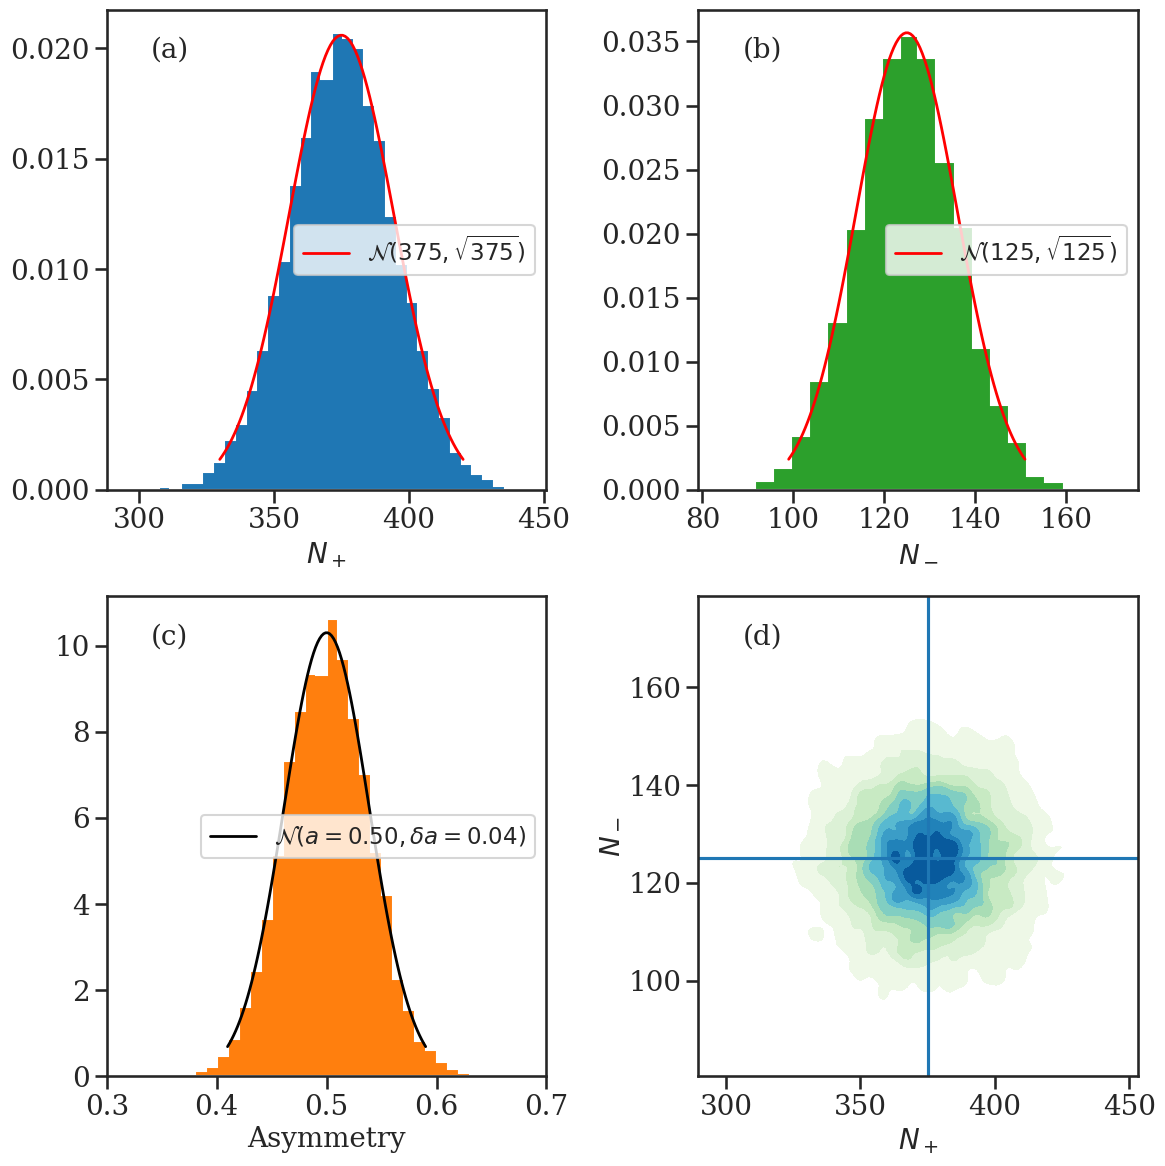

In [3]:
from scipy import stats
import itertools

n_samples = 10000
# sns.set_theme(style="white")
# set palette 
palette = sns.color_palette()

def generate_samples(true_count,n_samples):
    '''
    - Generate n_samples counts from a normal distribution with mean true_count and
    standard deviation np.sqrt(true_count).
    - Evaluate bins so that they are defined as one bin for each integer count
    - Create an x range for calculating the normal PDF
    '''
    sample_counts = np.rint(stats.norm.rvs(loc=true_count, scale=np.sqrt(true_count), size=n_samples)).astype(int)
    # Centre bins on integers for aesthetics...
    sample_bins   = np.arange(np.amin(sample_counts)-0.5,np.amax(sample_counts)+0.5,4)
    sample_range  = np.linspace(stats.norm.ppf(0.01,loc=true_count, scale=np.sqrt(true_count)),
                                stats.norm.ppf(0.99,loc=true_count, scale=np.sqrt(true_count)), 100)
    return  sample_counts, sample_bins, sample_range 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Sample distribution of N_+ ...
sample_plus_counts,sample_plus_bins,sample_plus_range = generate_samples(n_plus,n_samples)
# Histogram...
axs[0,0].hist(sample_plus_counts, bins=sample_plus_bins, density=True, histtype='stepfilled')
# Normal PDF...
n_plus_str = f'{n_plus:.0f}'
axs[0,0].plot(sample_plus_range, stats.norm.pdf(sample_plus_range,loc=n_plus, scale=np.sqrt(n_plus)), 
        'r-', lw=2, label=r'${\cal N}('+n_plus_str+',\sqrt{'+n_plus_str+'})$')
axs[0,0].set_xlabel(r'$N_+$')
axs[0,0].legend()
axs[0,0].annotate('(a)', xy=(0.1,0.9), xycoords='axes fraction', fontsize=20)

# Sample distribution of N_- ...
sample_minus_counts,sample_minus_bins,sample_minus_range = generate_samples(n_minus,n_samples)
# Histogram...
axs[0,1].hist(sample_minus_counts, bins=sample_minus_bins, density=True, histtype='stepfilled',color=palette[2])
# Normal PDF...
n_minus_str = f'{n_minus:.0f}'
axs[0,1].plot(sample_minus_range, stats.norm.pdf(sample_minus_range,loc=n_minus, scale=np.sqrt(n_minus)), 
        'r-', lw=2, label=r'${\cal N}('+n_minus_str+',\sqrt{'+n_minus_str+'})$')
axs[0,1].set_xlabel(r'$N_-$')
axs[0,1].legend()
axs[0,1].annotate('(b)', xy=(0.1,0.9), xycoords='axes fraction', fontsize=20)

# Distribution of asymmetries
sample_asymmetry = (sample_plus_counts-sample_minus_counts).astype(np.float32)/(sample_plus_counts+sample_minus_counts).astype(np.float32)
asymm_bins   = np.arange(0,1,0.01)
axs[1,0].hist(sample_asymmetry, bins=asymm_bins, density=True, histtype='stepfilled',color=palette[1])
axs[1,0].set_xlabel('Asymmetry')
axs[1,0].set_xlim(0.3,0.7)
asymm_range  = np.linspace(stats.norm.ppf(0.01,loc=asymm, scale=delta_asymm),
                           stats.norm.ppf(0.99,loc=asymm, scale=delta_asymm), 100)
a_str = f'{asymm:.2f}'
delta_a_str = f'{delta_asymm:.2f}'
axs[1,0].plot(asymm_range, stats.norm.pdf(asymm_range,loc=asymm, scale=delta_asymm), 
        'k-', lw=2, label=r'${\cal N}(a='+a_str+', \delta a='+delta_a_str+')$')
axs[1,0].legend()
axs[1,0].annotate('(c)', xy=(0.1,0.9), xycoords='axes fraction', fontsize=20)

# Additional plot to indicate independence of N_+ and N_-
axs[1,1] = sns.kdeplot(x=sample_plus_counts, y=sample_minus_counts, cmap="GnBu", fill=True, bw_adjust=.5)
axs[1,1].set_xlabel(r'$N_+$')
axs[1,1].set_ylabel(r'$N_-$')
axs[1,1].axvline(n_plus)
axs[1,1].axhline(n_minus)
axs[1,1].annotate('(d)', xy=(0.1,0.9), xycoords='axes fraction', fontsize=20)

plt.tight_layout()


In the plots above, (a) and (b) show the distributions of the sampled $N_+$ and $N_-$. Overlaid in red are the normal distributions ${\cal N}(375, \sqrt{375})$ and ${\cal N}(125, \sqrt{125})$ respectively.The agreement between PDF and distribution demonstrates that the sampling is fine. Plot (d) shows the combined distribution $(N_+,N_-)$, and indicates that the two random variables are drawn independently, since there is no correlation.

Plot (c) is the distribution of sampled asymmetries calculation from the sampled $N_+$ and $N_-$. Overlaid is the PDF ${\cal N}(0.5, 0.04)$, where the width is calculated from  $\delta a = \frac{2}{(n_+ + n_-)^2}\sqrt{n_+ n_- (n_+ + n_-)}$. The agreement between distribution and PDF shows that the expression for calculating an uncertainty in asymmetry using the formula above is valid.

## Recipe for Asymmetry Pseudodata Generation
For each point $x_i$:
1. Choose an effective count $n_e$.
2. Evaluate the input function $f(x_i) = a_i$
3. Calculate $n_+$ and $n_-$, and use these to generate an instance of the random variables $N_{i,+}$ and $N_{i,-}$
4. Calculate $A_i = \frac{N_{i,+} - N_{i,-}}{N_{i,+} + N_{i,-}}$ as the value of the pseudodatum
5. Calculate $\delta A_i = \frac{2}{(N_{i,+} + N_{i,-})^2}\sqrt{N_{i,+} N_{i,-} (N_{i,+} + N_{i,-})}$ as the uncertainty.

## Illustrative Example
To illustrate this process, let us take the combination of Legendre Polynomials of degree zero:

$$
f(x) = \frac{1}{2} P_2^0(x) + \frac{1}{2} P_4^0(x),
$$

and for a series of values of $x$, choosing a random effective count uniformly between 20 and 200:

$$
n_{i,e} = {\cal U}(20,200),
$$

use the recipe above to generate pseudodata. Plot with original curve for comparison:

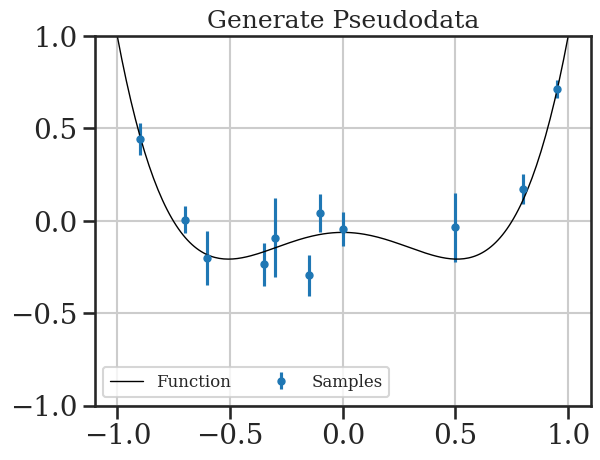

In [4]:
# Our funky function here
from scipy.special import legendre

def fn(xs):
    P2 = legendre(2)
    P4 = legendre(4)
    return 0.5*P2(xs) + 0.5*P4(xs)


x_fine = np.linspace(-1, 1, 200)
y_fine = fn(x_fine)


x_arr = np.array([-0.9, -0.7, -0.6, -0.35, -0.3, -0.15, -0.1, 0.0, 0.5, 0.8, 0.95])
y_arr = np.zeros(x_arr.shape)
y_arr_err = np.zeros(x_arr.shape)

for i, x in enumerate(x_arr):
    n_eff = np.random.uniform(low=20, high=200)
    asymm = fn(x) # asymmetry
    n_plus  = 0.5 * n_eff * ( 1.0 + asymm )
    n_minus = 0.5 * n_eff * ( 1.0 - asymm )
    n_plus_rv  = np.rint(stats.norm.rvs(loc=n_plus, scale=np.sqrt(n_plus))).astype(int)
    n_minus_rv = np.rint(stats.norm.rvs(loc=n_minus,scale=np.sqrt(n_minus))).astype(int)
    y_arr[i] = (n_plus_rv-n_minus_rv).astype(np.float32)/(n_plus_rv+n_minus_rv).astype(np.float32)
    y_arr_err[i]= 2 * np.sqrt((n_plus_rv+n_minus_rv)*n_plus_rv*n_minus_rv).astype(np.float32)/ \
                ((n_plus_rv+n_minus_rv).astype(np.float32)**2) 
#    print(i, n_eff, asymm,n_plus,n_minus,n_plus_rv,n_minus_rv, y_arr[i], y_arr_err[i])

plt.title('Generate Pseudodata')
plt.errorbar(x_arr, y_arr, yerr=y_arr_err, fmt="o", label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="k", lw=1)
plt.ylim(-1.0, 1.0), plt.legend(ncol=2, fontsize=12);
plt.grid(True)

This shows that the value of effective counts between 20 and 200 (for each setting) gives realistic sizes of error bars. This seems quite low, but is probably due to the effects of uncertainties in 'nuisance quantities' such as background, dilution, polarisation uncertainty, etc. when dealing with real experimental data. Will need to investigate this further... 

In [5]:
!pip install watermark

In [6]:
%load_ext watermark

### Computing Environment, for Reference 

In [7]:
%watermark
%watermark --iversions 

Last updated: 2023-02-26T14:09:20.095014+00:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.19.128-microsoft-standard
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.6.2
pandas    : 1.5.2
seaborn   : 0.12.1
numpy     : 1.23.5
scipy     : 1.9.3

